In [1]:
import numpy as np
import itertools
from biothings_client import get_client
import matplotlib.pyplot as plt
from os.path import join as pjoin
mg=get_client('gene')
diri='../data/highmoi'

#Load data
p=np.loadtxt(pjoin(diri,'8_pv.tsv.gz'))
lfc=np.loadtxt(pjoin(diri,'8_lfc.tsv.gz'))
dx=np.linspace(0,1,51)
with open(pjoin(diri,'0_gRNA.txt'),'r') as f:
    g=f.readlines()
g=np.array([x.strip() for x in g])
with open(pjoin(diri,'1_gene.txt'),'r') as f:
    t=f.readlines()
t=np.array([x.strip() for x in t])
tdict=dict(zip(t,range(len(t))))

In [2]:
#Find TSS-targeting gRNAs and their targets
gs=[np.nonzero([x.endswith('_negctrl') for x in g])[0],np.nonzero([x.split('_')[1]=='TSS' for x in g])[0]]
g1=[x.split('_')[-1] for x in g[gs[1]]]
q=mg.querymany(g1,scopes='symbol,alias',fields='ensembl.gene',species='human')
q=list(filter(lambda x:'ensembl' in x,q))
q=[[[y,x['query']] for y in x['ensembl']] if type(x['ensembl']) is list else [[x['ensembl'],x['query']]] for x in q]
q=[[x[0]['gene'],x[1]] for x in itertools.chain.from_iterable(q)]
q=list(filter(lambda x:x[0] in tdict,q))
q=[[tdict[x[0]],'{} ({})'.format(x[1],x[0])] for x in q]
q,qnames=[list(x) for x in zip(*q)]


querying 1-15...done.
Finished.
2 input query terms found dup hits:
	[('TSPO', 2), ('PIM1', 2)]
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


# P-value histograms
With the gRNA subset, false positives cannot be fully accounted for.

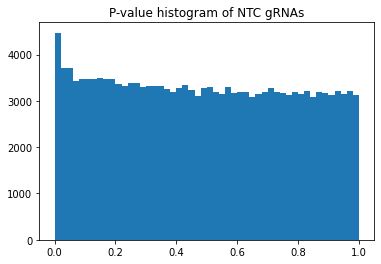

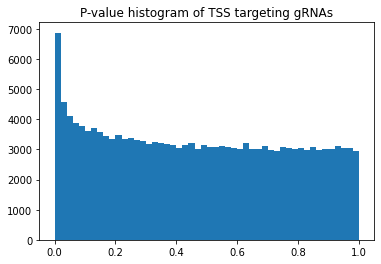

In [3]:
plt.hist(p[gs[0]].flatten(),bins=dx);
plt.title('P-value histogram of NTC gRNAs')
plt.show()
plt.hist(p[gs[1]].flatten(),bins=dx);
plt.title('P-value histogram of TSS targeting gRNAs');


# Heatmaps

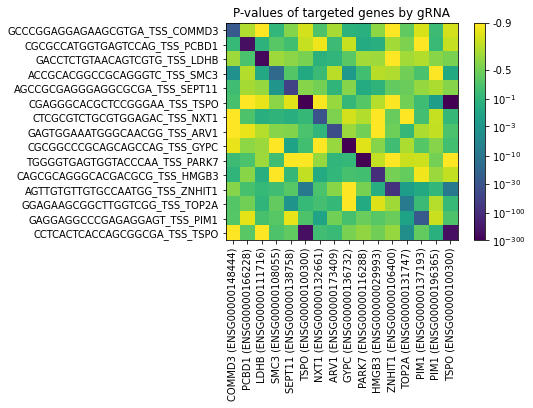

In [4]:
from matplotlib.ticker import FormatStrFormatter,FuncFormatter
func=lambda x:-np.log10(-np.log10(x+1E-301))
dy=func(p[gs[1]][:,q])
vmin=0
vmax=0.9
plt.imshow(dy,vmin=func(vmin),vmax=func(vmax));
plt.xticks(ticks=np.arange(len(qnames)),labels=qnames,rotation=90);
plt.yticks(ticks=np.arange(len(gs[1])),labels=g[gs[1]]);
plt.colorbar(ticks=func(np.array([0.9,0.5,1E-1,1E-3,1E-10,1E-31,1E-100,1E-301])),format=FuncFormatter(lambda x,pos:"$10^{"+str(int(-10**(-x)))+"}$" if -10**(-x)<-0.9 else str(int(np.round(-10**(1-10**(-x))))/10)));
plt.title('P-values of targeted genes by gRNA');

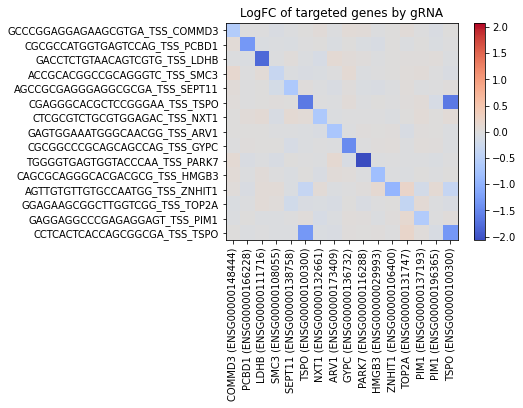

In [5]:
dy=lfc[gs[1]][:,q]
vmax=np.abs(dy).max()
vmin=-vmax
plt.imshow(dy,cmap='coolwarm',vmin=vmin,vmax=vmax);
plt.xticks(ticks=np.arange(len(qnames)),labels=qnames,rotation=90);
plt.yticks(ticks=np.arange(len(gs[1])),labels=g[gs[1]]);
plt.colorbar();
plt.title('LogFC of targeted genes by gRNA');